In [1]:
# Data
import os
import re

input_dir = '../data/oxfordpet/images'
img_size = (256, 256)

input_img_paths = sorted([os.path.join(input_dir, fname) 
                            for fname in os.listdir(input_dir)
                            if fname.endswith('.jpg')])

targets = sorted([re.sub(r'[0-9]', '', fname).rstrip('.jpg').rstrip('_') for fname in os.listdir(input_dir)
                        if fname.endswith('.jpg')])
num_classes = len(set(targets))


In [2]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from collections import defaultdict

class OxfordPetDataset(Dataset):
    def __init__(self, input_img_paths, targets, transform=None, target_transform=None):
        self.input_img_paths = input_img_paths
        self.transform = transform
        self.target_transform = target_transform
        self.targets = targets
        self.one_hot_targets = {name: idx for idx, name in enumerate(set(targets))}
        
    def __len__(self):
        return len(self.input_img_paths)
    
    def __getitem__(self, index):
        image = Image.open(input_img_paths[index]).convert("RGB")
        target = self.targets[index]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.one_hot_targets[target]
        
        return image, target

# transform = transforms.Compose([transforms.Resize((256, 256)), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# dataset = OxfordPetDataset(input_img_paths=input_img_paths, targets=targets, transform=transform, target_transform=True)
# image, target = next(iter(dataset))
# print(image, target)
# print(len(dataset))


/home/wonjun_jung/AI-Paper-Reproduce/.venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

class OxfordPetDataModule(pl.LightningDataModule):
    def __init__(self, img_size, batch_size, input_img_paths, targets):
        self.img_size = img_size
        self.batch_size = batch_size
        self.input_img_paths = input_img_paths
        self.targets = targets
    
    def setup(self, stage=None):
        transform = transforms.Compose([transforms.Resize((self.img_size)), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        dataset = OxfordPetDataset(input_img_paths=self.input_img_paths, targets=self.targets, transform=transform, target_transform=True)
        self.train_dataset, self.valid_dataset = random_split(dataset, [7000, 390])
    
    def train_dataloader(self):
        oxford_train = DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=8, shuffle=True)
        return oxford_train
    
    def val_dataloader(self):
        oxford_valid = DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=8, shuffle=False)
        return oxford_valid

# img_size = (256, 256)
# batch_size = 64
# dm = OxfordPetDataModule(img_size, batch_size, input_img_paths, targets)
# dm.setup()
# dataloader = dm.train_dataloader()
# for x, y in dataloader:
#     print(x.shape, y.shape)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import models
  

class ResNet(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, num_classes)
    
    def forward(self, input):
        out = self.backbone(input)
        return out
    
    def training_step(self, batch):
        x, y = batch
        pred = self(x)
        loss = F.cross_entropy(pred, y)
        self.log('train_loss', loss)

        pred_class = torch.argmax(pred, dim=-1)
        return {"loss": loss, "pred": pred_class.detach(), 'target': y.detach()}
    
    def training_epoch_end(self, outputs):
        correct = 0
        cnt = 0
        for o in outputs:
            correct += sum((o['pred'] == o['target']).to(dtype=torch.int))
            cnt += len(o['pred'])
        acc = correct/cnt
        self.log('train_acc', acc)

    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = F.cross_entropy(pred, y)
        self.log('val_loss', loss)

        pred_class = torch.argmax(pred, dim=-1)
        return {"loss": loss, "pred": pred_class.detach(), 'target': y.detach()}
    
    def validation_epoch_end(self, outputs):
        correct = 0
        cnt = 0
        for o in outputs:
            correct += sum((o['pred'] == o['target']).to(dtype=torch.int))
            cnt += len(o['pred'])
        acc = correct/cnt
        self.log('val_acc', acc)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

        
# net = ResNet(len(targets_dict))
# out = net(torch.randn(1, 3, 224, 224))
# print(out.shape)


In [5]:
from pytorch_lightning.callbacks import ModelCheckpoint

img_size = (256, 256)
batch_size = 64

data_module = OxfordPetDataModule(img_size, batch_size, input_img_paths, targets)
model = ResNet(num_classes=num_classes)
ckpt_callback = ModelCheckpoint(save_top_k=2, monitor='val_acc', mode='max')
trainer = pl.Trainer(gpus=1, max_epochs=10, callbacks=[ckpt_callback])
trainer.fit(model, data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 11.2 M
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.782    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 117/117 [00:08<00:00, 13.85it/s, loss=0.00138, v_num=0]


In [6]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

resnet = ResNet.load_from_checkpoint('./lightning_logs/version_0/checkpoints/epoch=4-step=549.ckpt')
resnet.eval()
# resnet.backbone.layer4[-1].register_forward_hook(get_activation('last_conv'))
resnet.backbone.layer4[1].conv2.register_forward_hook(get_activation('last_conv'))

In [7]:
def get_cam(model, input, target, img_size):
    pred = model(input)
    weights = model.backbone.fc.weight
    transform = transforms.Resize((img_size[1], img_size[0]))
    features = transform(activation['last_conv'].squeeze())

    ws = weights[target]

    print(target, torch.argmax(pred, dim=-1))

    cam = torch.sum(features * ws.view(ws.shape[0], 1, 1), dim=0)
    cam = (cam - cam.min())/ (cam.max()-cam.min())
    return cam


11 tensor([11])


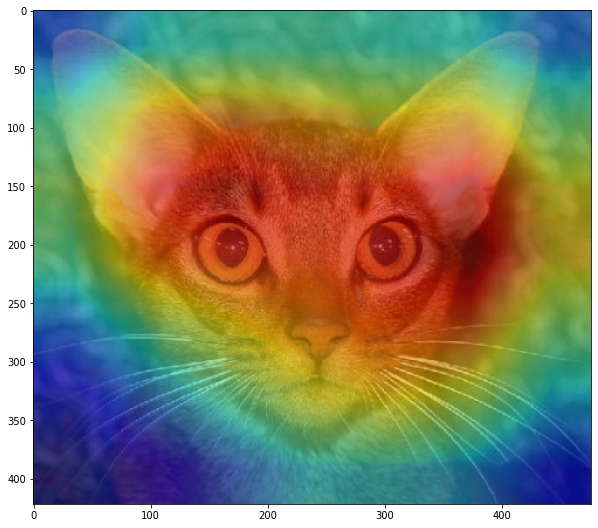

In [23]:
idx = 55
x, y = data_module.valid_dataset[idx]
img = Image.open(data_module.input_img_paths[idx]).convert('RGB')
img_size = img.size
transform = transforms.Compose([transforms.ToPILImage()])
cam = transform(get_cam(resnet, x.unsqueeze(0), y, img_size))

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.imshow(img)
axs.imshow(cam, cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')